# Cosmological Plots for Cosmolunch App

This notebook demonstrates key cosmological quantities using the [CLASS](http://class-code.net/) code. The following plots correspond to figures from *Dodelson, Modern Cosmology* and are intended to help visualize the evolution of the universe.
*These plots will serve as the foundation for the streaming features in the Cosmolunch app.*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
from classy import Class
import matplotlib
import healpy as hp

In [2]:
cosmo = Class()
common_settings = {
    'h': 0.6,
    'omega_b': 0.0224,
    'omega_cdm': 0.1188,
    'n_s': 0.96,
    'sigma8': 0.8,
    'l_max_scalars': 2500,
    'tau_reio': 0.054,
    'output': 'tCl,pCl,lCl,mTk,vTk',
    'gauge':'newtonian',
    'P_k_max_1/Mpc':10.0,
}

---

## 1. CMB Angular Power Spectrum 
**(Corresponds to Figure 1.10 in Dodelson)**  
- Plot the CMB angular power spectrum, $C_\ell$, as a function of multipole moment ($\ell$).
- Use a log-log scale to illustrate the behavior of the power spectrum at different scales.

---




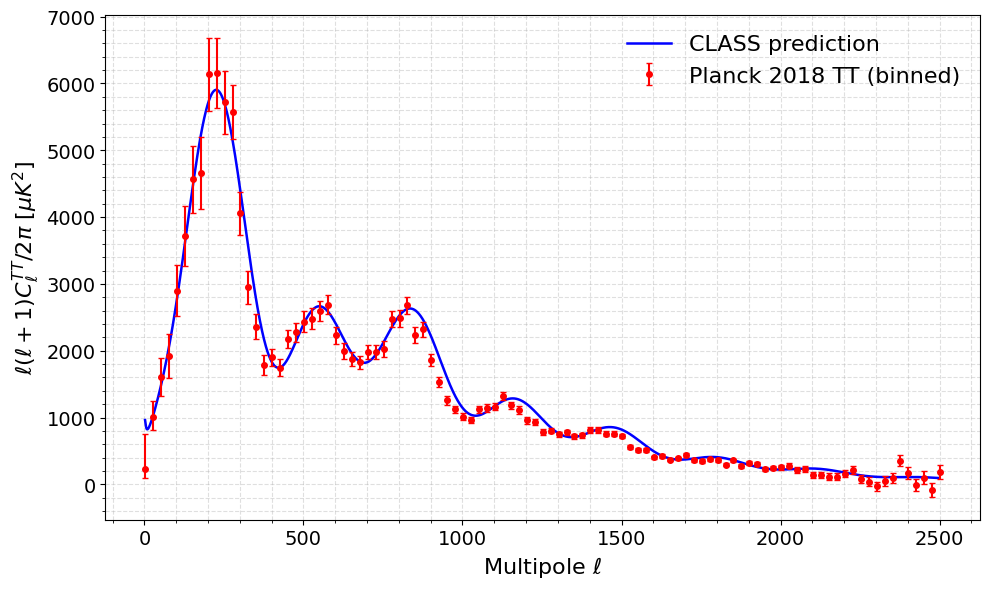

In [4]:
cosmo = Class()
cosmo.set(common_settings)
cosmo.compute()


# Get C_l^TT from CLASS (in [\mu K^2])
cl = cosmo.raw_cl(2500)
# Get the C_l^TT values
ells = cl['ell'][2:]  # drop ell=0,1
cl_tt = cl['tt'][2:] 

planck_data = np.loadtxt('/Users/r.kanaki/code/lunch_seminar/Data/COM_PowerSpect_CMB-TT-full_R3.01.txt')
ell_data = planck_data[:, 0]
cl_data = planck_data[:, 1]
cl_err_plus = planck_data[:, 2]
cl_err_minus = planck_data[:, 3]


# Downsample CLASS prediction
step = 25
ell_sampled = ell_data[::step]
cl_sampled = cl_data[::step]
cl_err_plus_sampled = cl_err_plus[::step]
cl_err_minus_sampled = cl_err_minus[::step]

T0 = 2.7255  * 1e6 # [K^2] to [μK^2]
# Convert to [μK^2]
cl_tt = cl_tt * T0**2  # [μK^2]

# Plotting (Planck-style)
plt.figure(figsize=(10, 6))
plt.plot(ells, cl_tt * ells * (ells + 1) / (2 * np.pi), lw=1.8, color='blue', label='CLASS prediction')

plt.errorbar(ell_sampled, cl_sampled, yerr=[cl_err_plus_sampled, cl_err_minus_sampled], fmt='o', markersize=4, capsize=2, color='red', label='Planck 2018 TT (binned)')

plt.xlabel(r'Multipole $\ell$', fontsize=16)
plt.ylabel(r'$\ell(\ell+1)C_\ell^{TT}/2\pi\ [\mu K^2]$', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tick_params(labelsize=14)
plt.legend(fontsize=16, loc='upper right', frameon=False)
# Optional: Add Planck-like tick styling
plt.minorticks_on()
plt.tight_layout()
plt.show()

# Cleanup CLASS
cosmo.struct_cleanup()
cosmo.empty()

---

## 2. CMB Temperature Anisotropies Map



---




/var/folders/mp/1wz15_md6t38m_mg0pdw5dv40000gn/T/ipykernel_89026/489735678.py:3: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_map = hp.synfast(cl_tt, nside=nside, lmax=lmax, new=True, verbose=False)


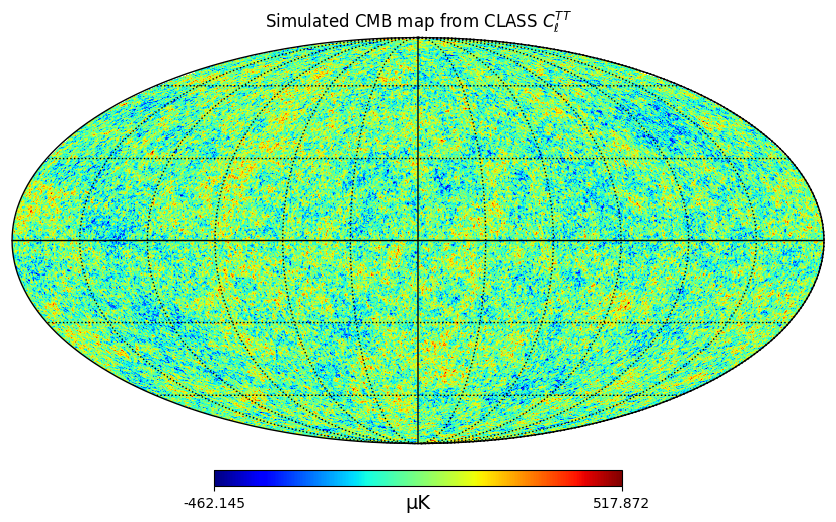

In [5]:
nside = 1024  # or 1024 for higher resolution
lmax = 2500
cmb_map = hp.synfast(cl_tt, nside=nside, lmax=lmax, new=True, verbose=False)
hp.mollview(cmb_map, title='Simulated CMB map from CLASS $C_\ell^{TT}$', unit='μK', cmap='jet')
hp.graticule()

/var/folders/mp/1wz15_md6t38m_mg0pdw5dv40000gn/T/ipykernel_89026/2646641808.py:12: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_map = hp.synfast(cl_tt, nside=nside, lmax=lmax, new=True, verbose=False)


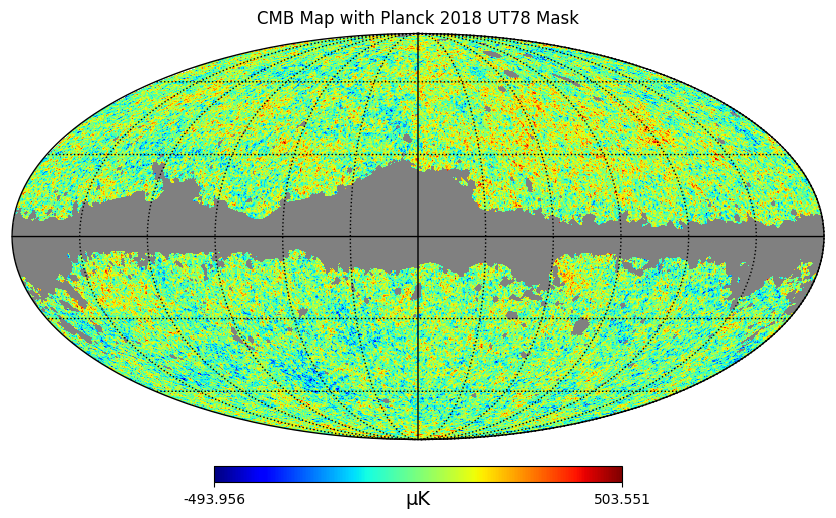

In [6]:
# === Load Planck 2018 UT78 Mask ===
mask_path = "/Users/r.kanaki/code/lunch_seminar/Data/COM_Mask_CMB-common-Mask-int_2048_R3.00.fits"
mask_2048 = hp.read_map(mask_path)

# Downgrade mask to match your map nside (e.g., 1024)
nside = 1024
mask = hp.ud_grade(mask_2048, nside_out=nside)
mask = np.where(mask > 0.9, 1, 0)  # Binarize mask

# === Simulate CMB map ===
lmax = 2500
cmb_map = hp.synfast(cl_tt, nside=nside, lmax=lmax, new=True, verbose=False)

# === Apply mask ===
cmb_map_masked = cmb_map * mask
# Set masked pixels to hp.UNSEEN so they appear as background in the plot
cmb_map_masked[mask == 0] = hp.UNSEEN
# === Plot ===
hp.mollview(cmb_map_masked, title='CMB Map with Planck 2018 UT78 Mask', unit='μK', cmap='jet')
hp.graticule()

---
## 3. Transferfunctions
**(Corresponds to Chapter 8)**  
- Plot the CMB angular power spectrum, $C_\ell$, as a function of multipole moment ($\ell$).
- Use a log-log scale to illustrate the behavior of the power spectrum at different scales.

---




In [7]:
M = Class()
M.empty()           
M.set(common_settings) 
M.set({'temperature contributions':'tsw'})
M.compute()
cl_TSW = M.raw_cl(2500)
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'eisw'})
M.compute()
cl_eISW = M.raw_cl(2500)
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'lisw'})
M.compute()
cl_lISW = M.raw_cl(2500)
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'dop'})
M.compute()
cl_Doppler = M.raw_cl(2500)
ell = cl_TSW['ell'][2:]  # drop ell=0,1

In [8]:
print("Shape of cl_TSW: ", cl_TSW['tt'].shape)
print("Shape of ell: ", ell.shape)

Shape of cl_TSW:  (2501,)
Shape of ell:  (2499,)


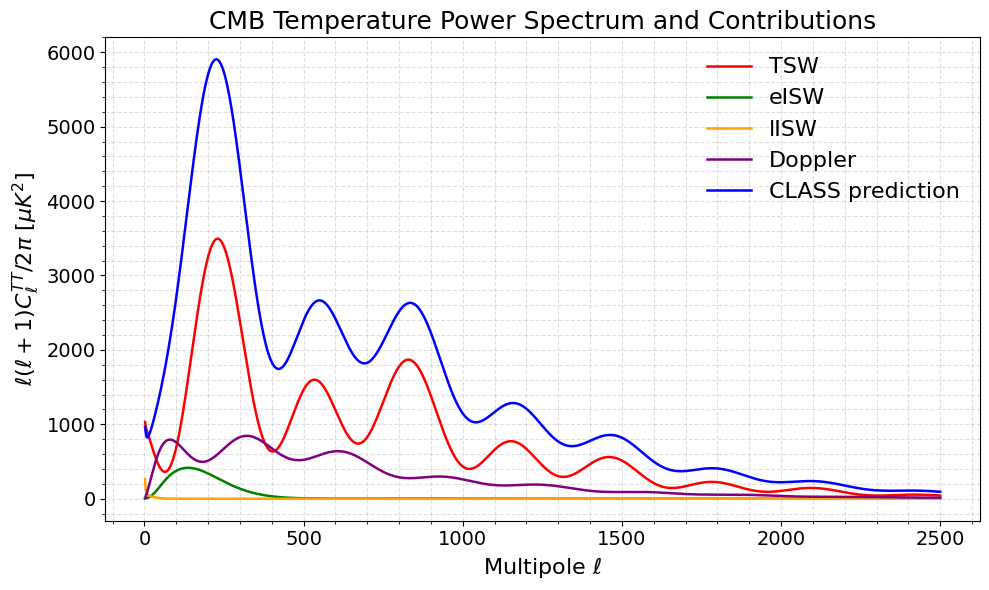

In [9]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the CLASS prediction
# Plot the individual contributions
ax.plot(ell, cl_TSW['tt'][2:] * ell * (ell + 1)*T0**2 / (2 * np.pi), lw=1.8, color='red', label='TSW')
ax.plot(ell, cl_eISW['tt'][2:] * ell * (ell + 1)*T0**2 / (2 * np.pi), lw=1.8, color='green', label='eISW')
ax.plot(ell, cl_lISW['tt'][2:] * ell * (ell + 1)*T0**2 / (2 * np.pi), lw=1.8, color='orange', label='lISW')
ax.plot(ell, cl_Doppler['tt'][2:] * ell * (ell + 1)*T0**2 / (2 * np.pi), lw=1.8, color='purple', label='Doppler')
ax.plot(ells, cl_tt * ells * (ells + 1) / (2 * np.pi), lw=1.8, color='blue', label='CLASS prediction')
# Add error bars for Planck data
# Set labels and title
ax.set_xlabel(r'Multipole $\ell$', fontsize=16)
ax.set_ylabel(r'$\ell(\ell+1)C_\ell^{TT}/2\pi\ [\mu K^2]$', fontsize=16)
ax.set_title('CMB Temperature Power Spectrum and Contributions', fontsize=18)
# Add grid
ax.grid(True, which='both', ls='--', alpha=0.4)
# Set tick parameters
ax.tick_params(labelsize=14)
# Add legend
ax.legend(fontsize=16, loc='upper right', frameon=False)
# Optional: Add Planck-like tick styling
ax.minorticks_on()
# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

---
## 4. The Growth factor
**(Corresponds to Figure 8.15 in Dodelson)**  
The growth factor is defined as the ratio of the density at time t to the density at the present time. It is a function of time and depends on the cosmological parameters. The growth factor is important because it tells us how structures in the universe grow over time.

---




In [10]:
common_settings = {# LambdaCDM parameters
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.12038,
                   'A_s':2.100549e-09,
                   'n_s': 0.9660499,
                   'tau_reio':0.05430842,
                   # output and precision parameters
                   'output':'tCl,mTk,vTk',
                   'l_max_scalars':5000,
                   'P_k_max_1/Mpc':10.0,
                   'gauge':'newtonian'
                   }

In [11]:
M = Class()
M.set(common_settings)
M.compute()
derived = M.get_current_derived_parameters(['z_rec','tau_rec','conformal_age'])
print (derived.keys())
z_rec = derived['z_rec']
z_rec = int(1000.*z_rec)/1000. # round down at 4 digits after coma
print ('z_rec=',z_rec)

dict_keys(['z_rec', 'tau_rec', 'conformal_age'])
z_rec= 1088.791


In [ ]:
one_time = M.get_transfer(z_rec)
print (one_time.keys())
k = one_time['k (h/Mpc)']
Theta0 = 0.25*one_time['d_g']
phi = one_time['phi']
psi = one_time['psi']
theta_b = one_time['t_b']

: 

---
## 5. CMB Polarization and Temperature Power Spectrum
**(Corresponds to Figure 10.11 in Dodelson)**


---




In [1]:
l_max_scalars = 2500
l_max_tensors = 2500
M_s= Class()
M_s.set(common_settings)
M_s.set({'output':'tCl,pCl,lCl','modes':'s','lensing':'yes',
       'l_max_scalars':l_max_scalars})
M_s.compute()

M_t = Class()
M_t.set(common_settings)
M_t.set({'output':'tCl,pCl,lCl','modes':'s,t','lensing':'yes','r':0.1,'n_t':0,
       'l_max_scalars':l_max_scalars,'l_max_tensors':l_max_tensors})
M_t.compute()


clt = M_t.raw_cl(l_max_scalars)
cls = M_s.raw_cl(l_max_scalars)
cl_lensed = M.lensed_cl(l_max_scalars)
font = {'size'   : 16, 'family':'STIXGeneral'}


axislabelfontsize='large'
matplotlib.rc('font', **font)
#matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

#################
#
# plotting
#
#################
#
plt.xlim([2,l_max_scalars])
plt.ylim([1.e-8,10])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"$r=0.1$")
plt.grid()
#
ell = cls['ell']
ellt = clt['ell']    
factor = 1.e10*ell*(ell+1.)/2./np.pi
factort = 1.e10*ellt*(ellt+1.)/2./np.pi
#
plt.loglog(ell,factor*cls['tt'],'r-',label=r'$\mathrm{TT(s)}$')
plt.loglog(ellt,factort*clt['tt'],'r:',label=r'$\mathrm{TT(t)}$')
plt.loglog(ell,factor*cls['ee'],'b-',label=r'$\mathrm{EE(s)}$')
plt.loglog(ellt,factort*clt['ee'],'b:',label=r'$\mathrm{EE(t)}$')
plt.loglog(ellt,factort*clt['bb'],'g:',label=r'$\mathrm{BB(t)}$')
plt.loglog(ell,factor*(cl_lensed['bb']-clt['bb']),'g-',label=r'$\mathrm{BB(lensing)}$')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

NameError: name 'Class' is not defined

---
## 6. CMB Polarization Map

---




/var/folders/mp/1wz15_md6t38m_mg0pdw5dv40000gn/T/ipykernel_27042/4209927300.py:12: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  cmb_maps = hp.synfast(cl_synfast, nside=nside, lmax=lmax, new=True, pol=True, verbose=False)


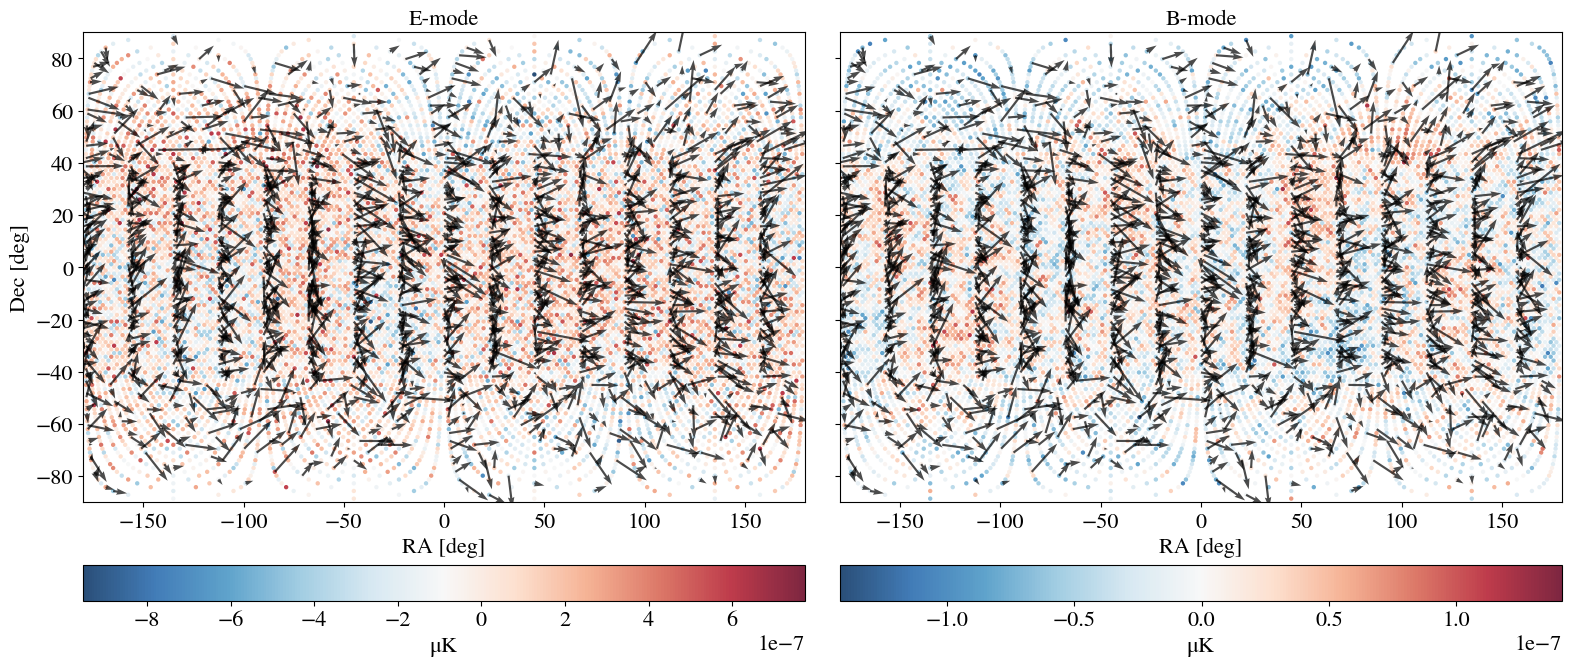

In [70]:
from matplotlib.patches import FancyArrowPatch

# Generate simulated CMB polarization maps (E and B modes) from the lensed power spectra
# Use cl_lensed['ee'] and cl_lensed['bb'] for E and B modes, respectively

# Prepare the input power spectra for synfast: [TT, EE, BB, TE]
# TT is not needed for pure polarization, but synfast expects a 4-list
cl_synfast = [cl_lensed['tt'], cl_lensed['ee'], cl_lensed['bb'], cl_lensed['te']]

# Generate Q and U maps (Stokes parameters) using healpy.synfast
# Set pol=True to get polarization maps
cmb_maps = hp.synfast(cl_synfast, nside=nside, lmax=lmax, new=True, pol=True, verbose=False)
cmb_T, cmb_Q, cmb_U = cmb_maps  # T, Q, U maps



# Optionally, decompose Q/U into E/B maps using healpy
alm_EB = hp.map2alm([cmb_T, cmb_Q, cmb_U], pol=True, lmax=lmax)
cmb_E = hp.alm2map(alm_EB[1], nside=nside, lmax=lmax)
cmb_B = hp.alm2map(alm_EB[2], nside=nside, lmax=lmax)

nside_plot = 32 # lower resolution for vector field visualization
npix = hp.nside2npix(nside_plot)
theta, phi = hp.pix2ang(nside_plot, np.arange(npix))

# Downsample Q/U/E/B maps for plotting
Q_plot = hp.ud_grade(cmb_Q, nside_plot)
U_plot = hp.ud_grade(cmb_U, nside_plot)
E_plot = hp.ud_grade(cmb_E, nside_plot)
B_plot = hp.ud_grade(cmb_B, nside_plot)

# Convert spherical to Mollweide projection coordinates
lon = np.rad2deg(phi) - 180  # [-180, 180]
lat = 90 - np.rad2deg(theta) # [-90, 90]

# Compute polarization angles and amplitudes
pol_angle = 0.5 * np.arctan2(U_plot, Q_plot)
pol_amp = np.sqrt(Q_plot**2 + U_plot**2)

# Normalize arrows for visibility
arrow_scale = 0.04 * pol_amp / pol_amp.max()

fig, axs = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Plot settings
arrow_skip = 8  # plot every Nth arrow for clarity
x = lon[::arrow_skip]
y = lat[::arrow_skip]
u = arrow_scale[::arrow_skip] * np.cos(pol_angle[::arrow_skip])
v = arrow_scale[::arrow_skip] * np.sin(pol_angle[::arrow_skip])

# E-mode
im0 = axs[0].scatter(lon, lat, c=E_plot, cmap='RdBu_r', s=10, lw=0, alpha=0.85)
axs[0].quiver(x, y, u, v, color='k', alpha=0.7, width=0.003, scale=0.4)
axs[0].set_title('E-mode', fontsize=16)
axs[0].set_xlabel('RA [deg]')
axs[0].set_ylabel('Dec [deg]')
axs[0].set_xlim([-180, 180])
axs[0].set_ylim([-90, 90])
fig.colorbar(im0, ax=axs[0], orientation='horizontal', pad=0.1, label='μK')

# B-mode
im1 = axs[1].scatter(lon, lat, c=B_plot, cmap='RdBu_r', s=10, lw=0, alpha=0.85)
axs[1].quiver(x, y, u, v, color='k', alpha=0.7, width=0.003, scale=0.4)
axs[1].set_title('B-mode', fontsize=16)
axs[1].set_xlabel('RA [deg]')
axs[1].set_xlim([-180, 180])
axs[1].set_ylim([-90, 90])
fig.colorbar(im1, ax=axs[1], orientation='horizontal', pad=0.1, label='μK')

plt.tight_layout()
plt.show()
